In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assignment3 Part2: Yolo Detection

We provide you a Yolo Detection network implementation, which is not finished. You are asked to complete the implementation by writing the loss function.

## What to do
You are asked to implement the loss function in ```yolo_loss.py```. You can use ```yolo_loss_debug_tool.ipynb``` to help you debug.

## What to submit
See the submission template for what to submit.

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [4]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.001
# num_epochs = 50
# batch_size = 24
num_epochs = 40
batch_size = 10

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [6]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [8]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector

In [9]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')



Starting epoch 1 / 40
Learning Rate for this epoch: 0.001
Epoch [1/40], Iter [5/502] Loss: 57.3399, average_loss: 66.6689
Epoch [1/40], Iter [10/502] Loss: 51.4409, average_loss: 60.9391
Epoch [1/40], Iter [15/502] Loss: 24.3790, average_loss: 51.5287
Epoch [1/40], Iter [20/502] Loss: 16.1261, average_loss: 43.9150
Epoch [1/40], Iter [25/502] Loss: 12.4998, average_loss: 37.9300
Epoch [1/40], Iter [30/502] Loss: 13.2219, average_loss: 33.6864
Epoch [1/40], Iter [35/502] Loss: 16.7616, average_loss: 30.5783
Epoch [1/40], Iter [40/502] Loss: 7.2453, average_loss: 27.9588
Epoch [1/40], Iter [45/502] Loss: 8.5444, average_loss: 26.1763
Epoch [1/40], Iter [50/502] Loss: 9.4917, average_loss: 24.5814
Epoch [1/40], Iter [55/502] Loss: 7.8932, average_loss: 23.2247
Epoch [1/40], Iter [60/502] Loss: 7.3725, average_loss: 22.0606
Epoch [1/40], Iter [65/502] Loss: 8.2639, average_loss: 21.0184
Epoch [1/40], Iter [70/502] Loss: 10.5047, average_loss: 20.1657
Epoch [1/40], Iter [75/502] Loss: 9.7

Epoch [2/40], Iter [135/502] Loss: 4.2398, average_loss: 5.1088
Epoch [2/40], Iter [140/502] Loss: 5.0578, average_loss: 5.0886
Epoch [2/40], Iter [145/502] Loss: 5.9105, average_loss: 5.1051
Epoch [2/40], Iter [150/502] Loss: 4.8398, average_loss: 5.0817
Epoch [2/40], Iter [155/502] Loss: 5.5084, average_loss: 5.1125
Epoch [2/40], Iter [160/502] Loss: 4.9306, average_loss: 5.1111
Epoch [2/40], Iter [165/502] Loss: 4.0596, average_loss: 5.1009
Epoch [2/40], Iter [170/502] Loss: 3.8547, average_loss: 5.0958
Epoch [2/40], Iter [175/502] Loss: 6.3219, average_loss: 5.0916
Epoch [2/40], Iter [180/502] Loss: 4.0190, average_loss: 5.0688
Epoch [2/40], Iter [185/502] Loss: 4.2028, average_loss: 5.0430
Epoch [2/40], Iter [190/502] Loss: 5.4731, average_loss: 5.0413
Epoch [2/40], Iter [195/502] Loss: 6.0791, average_loss: 5.0368
Epoch [2/40], Iter [200/502] Loss: 6.0894, average_loss: 5.0190
Epoch [2/40], Iter [205/502] Loss: 3.5088, average_loss: 5.0107
Epoch [2/40], Iter [210/502] Loss: 3.829

Epoch [3/40], Iter [270/502] Loss: 4.5356, average_loss: 4.3284
Epoch [3/40], Iter [275/502] Loss: 8.6779, average_loss: 4.3388
Epoch [3/40], Iter [280/502] Loss: 7.3366, average_loss: 4.3423
Epoch [3/40], Iter [285/502] Loss: 2.8857, average_loss: 4.3231
Epoch [3/40], Iter [290/502] Loss: 4.5520, average_loss: 4.3211
Epoch [3/40], Iter [295/502] Loss: 4.2566, average_loss: 4.3209
Epoch [3/40], Iter [300/502] Loss: 6.0479, average_loss: 4.3385
Epoch [3/40], Iter [305/502] Loss: 4.8737, average_loss: 4.3306
Epoch [3/40], Iter [310/502] Loss: 3.1394, average_loss: 4.3346
Epoch [3/40], Iter [315/502] Loss: 4.5392, average_loss: 4.3357
Epoch [3/40], Iter [320/502] Loss: 4.9066, average_loss: 4.3530
Epoch [3/40], Iter [325/502] Loss: 7.5554, average_loss: 4.3684
Epoch [3/40], Iter [330/502] Loss: 2.9136, average_loss: 4.3623
Epoch [3/40], Iter [335/502] Loss: 3.5710, average_loss: 4.3568
Epoch [3/40], Iter [340/502] Loss: 3.1218, average_loss: 4.3594
Epoch [3/40], Iter [345/502] Loss: 4.534

Epoch [4/40], Iter [405/502] Loss: 4.0765, average_loss: 4.0579
Epoch [4/40], Iter [410/502] Loss: 4.2554, average_loss: 4.0583
Epoch [4/40], Iter [415/502] Loss: 5.8735, average_loss: 4.0590
Epoch [4/40], Iter [420/502] Loss: 4.4853, average_loss: 4.0577
Epoch [4/40], Iter [425/502] Loss: 3.7737, average_loss: 4.0624
Epoch [4/40], Iter [430/502] Loss: 3.6176, average_loss: 4.0597
Epoch [4/40], Iter [435/502] Loss: 4.1736, average_loss: 4.0606
Epoch [4/40], Iter [440/502] Loss: 3.9005, average_loss: 4.0535
Epoch [4/40], Iter [445/502] Loss: 3.9596, average_loss: 4.0624
Epoch [4/40], Iter [450/502] Loss: 4.9738, average_loss: 4.0581
Epoch [4/40], Iter [455/502] Loss: 1.9765, average_loss: 4.0528
Epoch [4/40], Iter [460/502] Loss: 2.8129, average_loss: 4.0430
Epoch [4/40], Iter [465/502] Loss: 2.7571, average_loss: 4.0369
Epoch [4/40], Iter [470/502] Loss: 2.7670, average_loss: 4.0271
Epoch [4/40], Iter [475/502] Loss: 4.9836, average_loss: 4.0292
Epoch [4/40], Iter [480/502] Loss: 6.547

Epoch [6/40], Iter [35/502] Loss: 4.5721, average_loss: 3.5335
Epoch [6/40], Iter [40/502] Loss: 4.4053, average_loss: 3.5659
Epoch [6/40], Iter [45/502] Loss: 3.6605, average_loss: 3.5361
Epoch [6/40], Iter [50/502] Loss: 5.9070, average_loss: 3.5632
Epoch [6/40], Iter [55/502] Loss: 4.1581, average_loss: 3.5942
Epoch [6/40], Iter [60/502] Loss: 3.2074, average_loss: 3.5306
Epoch [6/40], Iter [65/502] Loss: 3.1735, average_loss: 3.5304
Epoch [6/40], Iter [70/502] Loss: 5.0649, average_loss: 3.5726
Epoch [6/40], Iter [75/502] Loss: 2.7093, average_loss: 3.5261
Epoch [6/40], Iter [80/502] Loss: 4.2952, average_loss: 3.5577
Epoch [6/40], Iter [85/502] Loss: 3.3719, average_loss: 3.5555
Epoch [6/40], Iter [90/502] Loss: 4.3273, average_loss: 3.5548
Epoch [6/40], Iter [95/502] Loss: 3.9735, average_loss: 3.5632
Epoch [6/40], Iter [100/502] Loss: 7.6149, average_loss: 3.5981
Epoch [6/40], Iter [105/502] Loss: 2.4913, average_loss: 3.5843
Epoch [6/40], Iter [110/502] Loss: 2.8936, average_lo

Epoch [7/40], Iter [175/502] Loss: 3.3969, average_loss: 3.6210
Epoch [7/40], Iter [180/502] Loss: 5.2076, average_loss: 3.6196
Epoch [7/40], Iter [185/502] Loss: 2.8969, average_loss: 3.6061
Epoch [7/40], Iter [190/502] Loss: 4.3500, average_loss: 3.6069
Epoch [7/40], Iter [195/502] Loss: 2.1038, average_loss: 3.6039
Epoch [7/40], Iter [200/502] Loss: 2.8154, average_loss: 3.5838
Epoch [7/40], Iter [205/502] Loss: 3.5884, average_loss: 3.5904
Epoch [7/40], Iter [210/502] Loss: 2.8209, average_loss: 3.5879
Epoch [7/40], Iter [215/502] Loss: 5.0672, average_loss: 3.5902
Epoch [7/40], Iter [220/502] Loss: 4.8530, average_loss: 3.5889
Epoch [7/40], Iter [225/502] Loss: 2.9245, average_loss: 3.5756
Epoch [7/40], Iter [230/502] Loss: 2.9438, average_loss: 3.5623
Epoch [7/40], Iter [235/502] Loss: 2.4959, average_loss: 3.5523
Epoch [7/40], Iter [240/502] Loss: 2.6517, average_loss: 3.5458
Epoch [7/40], Iter [245/502] Loss: 2.8109, average_loss: 3.5463
Epoch [7/40], Iter [250/502] Loss: 3.109

Epoch [8/40], Iter [310/502] Loss: 2.8547, average_loss: 3.3397
Epoch [8/40], Iter [315/502] Loss: 3.7488, average_loss: 3.3416
Epoch [8/40], Iter [320/502] Loss: 2.5538, average_loss: 3.3357
Epoch [8/40], Iter [325/502] Loss: 4.5276, average_loss: 3.3497
Epoch [8/40], Iter [330/502] Loss: 2.4521, average_loss: 3.3363
Epoch [8/40], Iter [335/502] Loss: 3.2155, average_loss: 3.3366
Epoch [8/40], Iter [340/502] Loss: 3.1904, average_loss: 3.3406
Epoch [8/40], Iter [345/502] Loss: 4.5284, average_loss: 3.3443
Epoch [8/40], Iter [350/502] Loss: 4.2250, average_loss: 3.3462
Epoch [8/40], Iter [355/502] Loss: 2.9270, average_loss: 3.3413
Epoch [8/40], Iter [360/502] Loss: 2.5884, average_loss: 3.3358
Epoch [8/40], Iter [365/502] Loss: 2.9626, average_loss: 3.3357
Epoch [8/40], Iter [370/502] Loss: 3.8081, average_loss: 3.3303
Epoch [8/40], Iter [375/502] Loss: 3.3363, average_loss: 3.3244
Epoch [8/40], Iter [380/502] Loss: 4.7568, average_loss: 3.3257
Epoch [8/40], Iter [385/502] Loss: 2.337

Epoch [9/40], Iter [445/502] Loss: 2.2500, average_loss: 3.1823
Epoch [9/40], Iter [450/502] Loss: 2.0929, average_loss: 3.1738
Epoch [9/40], Iter [455/502] Loss: 1.9820, average_loss: 3.1738
Epoch [9/40], Iter [460/502] Loss: 2.8949, average_loss: 3.1755
Epoch [9/40], Iter [465/502] Loss: 4.2182, average_loss: 3.1776
Epoch [9/40], Iter [470/502] Loss: 2.5746, average_loss: 3.1753
Epoch [9/40], Iter [475/502] Loss: 3.9871, average_loss: 3.1737
Epoch [9/40], Iter [480/502] Loss: 3.5595, average_loss: 3.1749
Epoch [9/40], Iter [485/502] Loss: 5.1085, average_loss: 3.1770
Epoch [9/40], Iter [490/502] Loss: 2.1334, average_loss: 3.1710
Epoch [9/40], Iter [495/502] Loss: 3.9482, average_loss: 3.1668
Epoch [9/40], Iter [500/502] Loss: 2.8072, average_loss: 3.1614
Updating best test loss: 3.30720


Starting epoch 10 / 40
Learning Rate for this epoch: 0.001
Epoch [10/40], Iter [5/502] Loss: 1.9435, average_loss: 2.7847
Epoch [10/40], Iter [10/502] Loss: 3.2161, average_loss: 2.6329
Epoch [10/4

Epoch [11/40], Iter [65/502] Loss: 2.6941, average_loss: 2.8264
Epoch [11/40], Iter [70/502] Loss: 3.0912, average_loss: 2.8847
Epoch [11/40], Iter [75/502] Loss: 3.2068, average_loss: 2.9098
Epoch [11/40], Iter [80/502] Loss: 3.6556, average_loss: 2.9093
Epoch [11/40], Iter [85/502] Loss: 6.2443, average_loss: 2.9465
Epoch [11/40], Iter [90/502] Loss: 2.1433, average_loss: 2.9308
Epoch [11/40], Iter [95/502] Loss: 2.3847, average_loss: 2.9394
Epoch [11/40], Iter [100/502] Loss: 1.9843, average_loss: 2.9119
Epoch [11/40], Iter [105/502] Loss: 3.1581, average_loss: 2.9127
Epoch [11/40], Iter [110/502] Loss: 2.6004, average_loss: 2.9282
Epoch [11/40], Iter [115/502] Loss: 2.9695, average_loss: 2.9133
Epoch [11/40], Iter [120/502] Loss: 3.9435, average_loss: 2.9227
Epoch [11/40], Iter [125/502] Loss: 2.0087, average_loss: 2.9270
Epoch [11/40], Iter [130/502] Loss: 3.1507, average_loss: 2.9146
Epoch [11/40], Iter [135/502] Loss: 2.6360, average_loss: 2.9054
Epoch [11/40], Iter [140/502] Lo

Epoch [12/40], Iter [195/502] Loss: 3.8080, average_loss: 2.9774
Epoch [12/40], Iter [200/502] Loss: 5.2645, average_loss: 2.9838
Epoch [12/40], Iter [205/502] Loss: 2.2823, average_loss: 2.9810
Epoch [12/40], Iter [210/502] Loss: 3.4773, average_loss: 2.9699
Epoch [12/40], Iter [215/502] Loss: 2.9584, average_loss: 2.9732
Epoch [12/40], Iter [220/502] Loss: 3.3424, average_loss: 2.9667
Epoch [12/40], Iter [225/502] Loss: 4.5118, average_loss: 2.9652
Epoch [12/40], Iter [230/502] Loss: 1.9178, average_loss: 2.9670
Epoch [12/40], Iter [235/502] Loss: 2.5925, average_loss: 2.9590
Epoch [12/40], Iter [240/502] Loss: 3.0158, average_loss: 2.9615
Epoch [12/40], Iter [245/502] Loss: 2.7309, average_loss: 2.9472
Epoch [12/40], Iter [250/502] Loss: 2.4131, average_loss: 2.9387
Epoch [12/40], Iter [255/502] Loss: 2.1377, average_loss: 2.9342
Epoch [12/40], Iter [260/502] Loss: 2.8756, average_loss: 2.9278
Epoch [12/40], Iter [265/502] Loss: 4.0695, average_loss: 2.9469
Epoch [12/40], Iter [270/

Epoch [13/40], Iter [320/502] Loss: 1.9045, average_loss: 2.8832
Epoch [13/40], Iter [325/502] Loss: 1.8465, average_loss: 2.8783
Epoch [13/40], Iter [330/502] Loss: 3.2640, average_loss: 2.8761
Epoch [13/40], Iter [335/502] Loss: 2.9918, average_loss: 2.8751
Epoch [13/40], Iter [340/502] Loss: 3.4621, average_loss: 2.8750
Epoch [13/40], Iter [345/502] Loss: 1.7387, average_loss: 2.8679
Epoch [13/40], Iter [350/502] Loss: 3.1635, average_loss: 2.8685
Epoch [13/40], Iter [355/502] Loss: 2.6279, average_loss: 2.8811
Epoch [13/40], Iter [360/502] Loss: 1.6917, average_loss: 2.8784
Epoch [13/40], Iter [365/502] Loss: 2.7477, average_loss: 2.8723
Epoch [13/40], Iter [370/502] Loss: 3.0599, average_loss: 2.8726
Epoch [13/40], Iter [375/502] Loss: 1.8603, average_loss: 2.8748
Epoch [13/40], Iter [380/502] Loss: 2.4607, average_loss: 2.8727
Epoch [13/40], Iter [385/502] Loss: 2.6267, average_loss: 2.8687
Epoch [13/40], Iter [390/502] Loss: 2.7924, average_loss: 2.8696
Epoch [13/40], Iter [395/

Epoch [14/40], Iter [450/502] Loss: 3.1148, average_loss: 2.7533
Epoch [14/40], Iter [455/502] Loss: 2.5600, average_loss: 2.7493
Epoch [14/40], Iter [460/502] Loss: 2.2637, average_loss: 2.7515
Epoch [14/40], Iter [465/502] Loss: 3.2454, average_loss: 2.7503
Epoch [14/40], Iter [470/502] Loss: 1.9921, average_loss: 2.7497
Epoch [14/40], Iter [475/502] Loss: 2.2667, average_loss: 2.7534
Epoch [14/40], Iter [480/502] Loss: 2.9016, average_loss: 2.7481
Epoch [14/40], Iter [485/502] Loss: 3.1885, average_loss: 2.7550
Epoch [14/40], Iter [490/502] Loss: 3.0708, average_loss: 2.7604
Epoch [14/40], Iter [495/502] Loss: 1.8616, average_loss: 2.7586
Epoch [14/40], Iter [500/502] Loss: 1.8910, average_loss: 2.7608
Updating best test loss: 3.05258


Starting epoch 15 / 40
Learning Rate for this epoch: 0.001
Epoch [15/40], Iter [5/502] Loss: 2.6406, average_loss: 2.7604
Epoch [15/40], Iter [10/502] Loss: 2.3794, average_loss: 3.0425
Epoch [15/40], Iter [15/502] Loss: 2.0225, average_loss: 2.7843


Epoch [16/40], Iter [70/502] Loss: 2.4985, average_loss: 2.5365
Epoch [16/40], Iter [75/502] Loss: 4.1933, average_loss: 2.5422
Epoch [16/40], Iter [80/502] Loss: 2.3832, average_loss: 2.5766
Epoch [16/40], Iter [85/502] Loss: 2.1968, average_loss: 2.5548
Epoch [16/40], Iter [90/502] Loss: 2.6890, average_loss: 2.5479
Epoch [16/40], Iter [95/502] Loss: 1.9978, average_loss: 2.5516
Epoch [16/40], Iter [100/502] Loss: 2.0979, average_loss: 2.5558
Epoch [16/40], Iter [105/502] Loss: 2.3588, average_loss: 2.5389
Epoch [16/40], Iter [110/502] Loss: 2.0530, average_loss: 2.5276
Epoch [16/40], Iter [115/502] Loss: 2.4378, average_loss: 2.5176
Epoch [16/40], Iter [120/502] Loss: 2.1377, average_loss: 2.5059
Epoch [16/40], Iter [125/502] Loss: 3.2430, average_loss: 2.5250
Epoch [16/40], Iter [130/502] Loss: 2.6127, average_loss: 2.5317
Epoch [16/40], Iter [135/502] Loss: 3.0014, average_loss: 2.5328
Epoch [16/40], Iter [140/502] Loss: 2.4727, average_loss: 2.5403
Epoch [16/40], Iter [145/502] L

Epoch [17/40], Iter [195/502] Loss: 2.4461, average_loss: 2.5049
Epoch [17/40], Iter [200/502] Loss: 2.1916, average_loss: 2.5024
Epoch [17/40], Iter [205/502] Loss: 2.8987, average_loss: 2.5118
Epoch [17/40], Iter [210/502] Loss: 2.8868, average_loss: 2.5219
Epoch [17/40], Iter [215/502] Loss: 3.2682, average_loss: 2.5386
Epoch [17/40], Iter [220/502] Loss: 2.1427, average_loss: 2.5272
Epoch [17/40], Iter [225/502] Loss: 2.0158, average_loss: 2.5343
Epoch [17/40], Iter [230/502] Loss: 2.4414, average_loss: 2.5380
Epoch [17/40], Iter [235/502] Loss: 1.9237, average_loss: 2.5417
Epoch [17/40], Iter [240/502] Loss: 2.5368, average_loss: 2.5343
Epoch [17/40], Iter [245/502] Loss: 2.0624, average_loss: 2.5363
Epoch [17/40], Iter [250/502] Loss: 2.5965, average_loss: 2.5462
Epoch [17/40], Iter [255/502] Loss: 4.1129, average_loss: 2.5711
Epoch [17/40], Iter [260/502] Loss: 1.6465, average_loss: 2.5663
Epoch [17/40], Iter [265/502] Loss: 3.1013, average_loss: 2.5708
Epoch [17/40], Iter [270/

Epoch [18/40], Iter [325/502] Loss: 2.1062, average_loss: 2.4665
Epoch [18/40], Iter [330/502] Loss: 2.1444, average_loss: 2.4663
Epoch [18/40], Iter [335/502] Loss: 3.6395, average_loss: 2.4674
Epoch [18/40], Iter [340/502] Loss: 2.6239, average_loss: 2.4787
Epoch [18/40], Iter [345/502] Loss: 2.0501, average_loss: 2.4797
Epoch [18/40], Iter [350/502] Loss: 1.7375, average_loss: 2.4789
Epoch [18/40], Iter [355/502] Loss: 1.4417, average_loss: 2.4693
Epoch [18/40], Iter [360/502] Loss: 1.9794, average_loss: 2.4714
Epoch [18/40], Iter [365/502] Loss: 3.4571, average_loss: 2.4805
Epoch [18/40], Iter [370/502] Loss: 1.6851, average_loss: 2.4761
Epoch [18/40], Iter [375/502] Loss: 2.4184, average_loss: 2.4700
Epoch [18/40], Iter [380/502] Loss: 2.0100, average_loss: 2.4694
Epoch [18/40], Iter [385/502] Loss: 3.3613, average_loss: 2.4768
Epoch [18/40], Iter [390/502] Loss: 4.2728, average_loss: 2.4895
Epoch [18/40], Iter [395/502] Loss: 2.2766, average_loss: 2.4900
Epoch [18/40], Iter [400/

Epoch [19/40], Iter [450/502] Loss: 2.8370, average_loss: 2.4443
Epoch [19/40], Iter [455/502] Loss: 1.9953, average_loss: 2.4500
Epoch [19/40], Iter [460/502] Loss: 3.4129, average_loss: 2.4536
Epoch [19/40], Iter [465/502] Loss: 2.1787, average_loss: 2.4558
Epoch [19/40], Iter [470/502] Loss: 3.9476, average_loss: 2.4575
Epoch [19/40], Iter [475/502] Loss: 1.8414, average_loss: 2.4523
Epoch [19/40], Iter [480/502] Loss: 2.8619, average_loss: 2.4513
Epoch [19/40], Iter [485/502] Loss: 3.4118, average_loss: 2.4530
Epoch [19/40], Iter [490/502] Loss: 1.6652, average_loss: 2.4527
Epoch [19/40], Iter [495/502] Loss: 1.8972, average_loss: 2.4556
Epoch [19/40], Iter [500/502] Loss: 3.1385, average_loss: 2.4575
Updating best test loss: 2.86794


Starting epoch 20 / 40
Learning Rate for this epoch: 0.001
Epoch [20/40], Iter [5/502] Loss: 2.1334, average_loss: 1.9188
Epoch [20/40], Iter [10/502] Loss: 2.4218, average_loss: 2.1633
Epoch [20/40], Iter [15/502] Loss: 2.7711, average_loss: 2.4107


Epoch [21/40], Iter [70/502] Loss: 4.2255, average_loss: 2.3021
Epoch [21/40], Iter [75/502] Loss: 1.0489, average_loss: 2.2975
Epoch [21/40], Iter [80/502] Loss: 3.7805, average_loss: 2.3284
Epoch [21/40], Iter [85/502] Loss: 2.2184, average_loss: 2.3319
Epoch [21/40], Iter [90/502] Loss: 1.8315, average_loss: 2.3263
Epoch [21/40], Iter [95/502] Loss: 2.7312, average_loss: 2.3389
Epoch [21/40], Iter [100/502] Loss: 2.6037, average_loss: 2.3609
Epoch [21/40], Iter [105/502] Loss: 2.3800, average_loss: 2.3687
Epoch [21/40], Iter [110/502] Loss: 2.1108, average_loss: 2.3606
Epoch [21/40], Iter [115/502] Loss: 2.7267, average_loss: 2.3949
Epoch [21/40], Iter [120/502] Loss: 1.5323, average_loss: 2.3765
Epoch [21/40], Iter [125/502] Loss: 1.8059, average_loss: 2.3701
Epoch [21/40], Iter [130/502] Loss: 2.1163, average_loss: 2.3621
Epoch [21/40], Iter [135/502] Loss: 3.3885, average_loss: 2.3830
Epoch [21/40], Iter [140/502] Loss: 1.9962, average_loss: 2.3832
Epoch [21/40], Iter [145/502] L

Epoch [22/40], Iter [200/502] Loss: 2.2167, average_loss: 2.2201
Epoch [22/40], Iter [205/502] Loss: 2.8463, average_loss: 2.2304
Epoch [22/40], Iter [210/502] Loss: 2.0129, average_loss: 2.2456
Epoch [22/40], Iter [215/502] Loss: 2.2514, average_loss: 2.2423
Epoch [22/40], Iter [220/502] Loss: 1.4773, average_loss: 2.2344
Epoch [22/40], Iter [225/502] Loss: 1.4647, average_loss: 2.2567
Epoch [22/40], Iter [230/502] Loss: 1.7283, average_loss: 2.2512
Epoch [22/40], Iter [235/502] Loss: 2.0612, average_loss: 2.2534
Epoch [22/40], Iter [240/502] Loss: 2.4925, average_loss: 2.2520
Epoch [22/40], Iter [245/502] Loss: 2.7376, average_loss: 2.2510
Epoch [22/40], Iter [250/502] Loss: 1.6385, average_loss: 2.2513
Epoch [22/40], Iter [255/502] Loss: 2.5136, average_loss: 2.2469
Epoch [22/40], Iter [260/502] Loss: 2.0267, average_loss: 2.2454
Epoch [22/40], Iter [265/502] Loss: 1.4523, average_loss: 2.2474
Epoch [22/40], Iter [270/502] Loss: 3.3098, average_loss: 2.2548
Epoch [22/40], Iter [275/

Epoch [23/40], Iter [330/502] Loss: 2.6871, average_loss: 2.2817
Epoch [23/40], Iter [335/502] Loss: 2.3777, average_loss: 2.2886
Epoch [23/40], Iter [340/502] Loss: 2.0167, average_loss: 2.2898
Epoch [23/40], Iter [345/502] Loss: 2.8929, average_loss: 2.2893
Epoch [23/40], Iter [350/502] Loss: 2.2415, average_loss: 2.2825
Epoch [23/40], Iter [355/502] Loss: 2.0106, average_loss: 2.2869
Epoch [23/40], Iter [360/502] Loss: 3.0001, average_loss: 2.2835
Epoch [23/40], Iter [365/502] Loss: 2.1961, average_loss: 2.2819
Epoch [23/40], Iter [370/502] Loss: 1.7294, average_loss: 2.2846
Epoch [23/40], Iter [375/502] Loss: 2.9021, average_loss: 2.2797
Epoch [23/40], Iter [380/502] Loss: 3.1418, average_loss: 2.2774
Epoch [23/40], Iter [385/502] Loss: 1.7311, average_loss: 2.2714
Epoch [23/40], Iter [390/502] Loss: 1.9870, average_loss: 2.2701
Epoch [23/40], Iter [395/502] Loss: 2.5228, average_loss: 2.2749
Epoch [23/40], Iter [400/502] Loss: 2.0569, average_loss: 2.2871
Epoch [23/40], Iter [405/

Epoch [24/40], Iter [455/502] Loss: 2.8184, average_loss: 2.2253
Epoch [24/40], Iter [460/502] Loss: 1.9261, average_loss: 2.2301
Epoch [24/40], Iter [465/502] Loss: 1.6627, average_loss: 2.2339
Epoch [24/40], Iter [470/502] Loss: 3.1490, average_loss: 2.2356
Epoch [24/40], Iter [475/502] Loss: 3.0462, average_loss: 2.2353
Epoch [24/40], Iter [480/502] Loss: 2.1526, average_loss: 2.2339
Epoch [24/40], Iter [485/502] Loss: 2.5644, average_loss: 2.2356
Epoch [24/40], Iter [490/502] Loss: 1.8528, average_loss: 2.2338
Epoch [24/40], Iter [495/502] Loss: 2.5318, average_loss: 2.2341
Epoch [24/40], Iter [500/502] Loss: 1.6734, average_loss: 2.2327
Updating best test loss: 2.73230


Starting epoch 25 / 40
Learning Rate for this epoch: 0.001
Epoch [25/40], Iter [5/502] Loss: 2.0847, average_loss: 2.1025
Epoch [25/40], Iter [10/502] Loss: 2.1946, average_loss: 2.0132
Epoch [25/40], Iter [15/502] Loss: 2.4483, average_loss: 2.1382
Epoch [25/40], Iter [20/502] Loss: 3.3412, average_loss: 2.2881
E

Epoch [26/40], Iter [75/502] Loss: 1.7936, average_loss: 2.2646
Epoch [26/40], Iter [80/502] Loss: 1.9340, average_loss: 2.2949
Epoch [26/40], Iter [85/502] Loss: 1.9170, average_loss: 2.2675
Epoch [26/40], Iter [90/502] Loss: 2.4081, average_loss: 2.2926
Epoch [26/40], Iter [95/502] Loss: 1.5581, average_loss: 2.2848
Epoch [26/40], Iter [100/502] Loss: 2.1801, average_loss: 2.2988
Epoch [26/40], Iter [105/502] Loss: 2.4535, average_loss: 2.3292
Epoch [26/40], Iter [110/502] Loss: 3.3723, average_loss: 2.3346
Epoch [26/40], Iter [115/502] Loss: 2.5630, average_loss: 2.3255
Epoch [26/40], Iter [120/502] Loss: 1.7726, average_loss: 2.3018
Epoch [26/40], Iter [125/502] Loss: 2.9580, average_loss: 2.3093
Epoch [26/40], Iter [130/502] Loss: 2.1101, average_loss: 2.2916
Epoch [26/40], Iter [135/502] Loss: 2.3543, average_loss: 2.2837
Epoch [26/40], Iter [140/502] Loss: 3.1884, average_loss: 2.2816
Epoch [26/40], Iter [145/502] Loss: 3.7759, average_loss: 2.2918
Epoch [26/40], Iter [150/502] 

Epoch [27/40], Iter [205/502] Loss: 3.0422, average_loss: 2.2154
Epoch [27/40], Iter [210/502] Loss: 2.1805, average_loss: 2.2197
Epoch [27/40], Iter [215/502] Loss: 3.3852, average_loss: 2.2237
Epoch [27/40], Iter [220/502] Loss: 2.5663, average_loss: 2.2213
Epoch [27/40], Iter [225/502] Loss: 2.0851, average_loss: 2.2170
Epoch [27/40], Iter [230/502] Loss: 2.1515, average_loss: 2.2141
Epoch [27/40], Iter [235/502] Loss: 1.9621, average_loss: 2.2054
Epoch [27/40], Iter [240/502] Loss: 2.1120, average_loss: 2.2060
Epoch [27/40], Iter [245/502] Loss: 1.9388, average_loss: 2.2015
Epoch [27/40], Iter [250/502] Loss: 1.5922, average_loss: 2.1937
Epoch [27/40], Iter [255/502] Loss: 2.0217, average_loss: 2.1932
Epoch [27/40], Iter [260/502] Loss: 1.6426, average_loss: 2.1920
Epoch [27/40], Iter [265/502] Loss: 1.6745, average_loss: 2.1905
Epoch [27/40], Iter [270/502] Loss: 2.1538, average_loss: 2.1868
Epoch [27/40], Iter [275/502] Loss: 1.9434, average_loss: 2.1875
Epoch [27/40], Iter [280/

Epoch [28/40], Iter [335/502] Loss: 1.4924, average_loss: 2.1201
Epoch [28/40], Iter [340/502] Loss: 1.6338, average_loss: 2.1192
Epoch [28/40], Iter [345/502] Loss: 2.1100, average_loss: 2.1269
Epoch [28/40], Iter [350/502] Loss: 1.7005, average_loss: 2.1237
Epoch [28/40], Iter [355/502] Loss: 2.1967, average_loss: 2.1258
Epoch [28/40], Iter [360/502] Loss: 1.8144, average_loss: 2.1287
Epoch [28/40], Iter [365/502] Loss: 1.3502, average_loss: 2.1239
Epoch [28/40], Iter [370/502] Loss: 2.3598, average_loss: 2.1288
Epoch [28/40], Iter [375/502] Loss: 1.7491, average_loss: 2.1301
Epoch [28/40], Iter [380/502] Loss: 2.8187, average_loss: 2.1277
Epoch [28/40], Iter [385/502] Loss: 2.2515, average_loss: 2.1248
Epoch [28/40], Iter [390/502] Loss: 2.1783, average_loss: 2.1219
Epoch [28/40], Iter [395/502] Loss: 2.3502, average_loss: 2.1221
Epoch [28/40], Iter [400/502] Loss: 1.7801, average_loss: 2.1187
Epoch [28/40], Iter [405/502] Loss: 1.6321, average_loss: 2.1170
Epoch [28/40], Iter [410/

Epoch [29/40], Iter [465/502] Loss: 1.2330, average_loss: 2.1140
Epoch [29/40], Iter [470/502] Loss: 1.7284, average_loss: 2.1147
Epoch [29/40], Iter [475/502] Loss: 1.8721, average_loss: 2.1141
Epoch [29/40], Iter [480/502] Loss: 3.4311, average_loss: 2.1164
Epoch [29/40], Iter [485/502] Loss: 2.1149, average_loss: 2.1189
Epoch [29/40], Iter [490/502] Loss: 2.4846, average_loss: 2.1190
Epoch [29/40], Iter [495/502] Loss: 2.1578, average_loss: 2.1182
Epoch [29/40], Iter [500/502] Loss: 2.4606, average_loss: 2.1185


Starting epoch 30 / 40
Learning Rate for this epoch: 0.001
Epoch [30/40], Iter [5/502] Loss: 1.2174, average_loss: 1.8435
Epoch [30/40], Iter [10/502] Loss: 1.9280, average_loss: 1.8829
Epoch [30/40], Iter [15/502] Loss: 1.9531, average_loss: 1.9547
Epoch [30/40], Iter [20/502] Loss: 3.1226, average_loss: 2.0726
Epoch [30/40], Iter [25/502] Loss: 1.8744, average_loss: 2.0632
Epoch [30/40], Iter [30/502] Loss: 2.8830, average_loss: 2.0543
Epoch [30/40], Iter [35/502] Loss: 1

Epoch [31/40], Iter [90/502] Loss: 1.9943, average_loss: 1.9118
Epoch [31/40], Iter [95/502] Loss: 1.4361, average_loss: 1.9048
Epoch [31/40], Iter [100/502] Loss: 1.9638, average_loss: 1.9226
Epoch [31/40], Iter [105/502] Loss: 1.5082, average_loss: 1.9280
Epoch [31/40], Iter [110/502] Loss: 1.8865, average_loss: 1.9412
Epoch [31/40], Iter [115/502] Loss: 1.4639, average_loss: 1.9299
Epoch [31/40], Iter [120/502] Loss: 2.1029, average_loss: 1.9360
Epoch [31/40], Iter [125/502] Loss: 1.4707, average_loss: 1.9464
Epoch [31/40], Iter [130/502] Loss: 3.5378, average_loss: 1.9531
Epoch [31/40], Iter [135/502] Loss: 1.3528, average_loss: 1.9392
Epoch [31/40], Iter [140/502] Loss: 1.7215, average_loss: 1.9273
Epoch [31/40], Iter [145/502] Loss: 1.3344, average_loss: 1.9239
Epoch [31/40], Iter [150/502] Loss: 1.9103, average_loss: 1.9431
Epoch [31/40], Iter [155/502] Loss: 2.3942, average_loss: 1.9506
Epoch [31/40], Iter [160/502] Loss: 1.9371, average_loss: 1.9504
Epoch [31/40], Iter [165/50

Epoch [32/40], Iter [215/502] Loss: 1.2810, average_loss: 1.8994
Epoch [32/40], Iter [220/502] Loss: 1.5348, average_loss: 1.9017
Epoch [32/40], Iter [225/502] Loss: 1.6067, average_loss: 1.9027
Epoch [32/40], Iter [230/502] Loss: 2.3496, average_loss: 1.8998
Epoch [32/40], Iter [235/502] Loss: 1.3337, average_loss: 1.8939
Epoch [32/40], Iter [240/502] Loss: 2.2046, average_loss: 1.8982
Epoch [32/40], Iter [245/502] Loss: 1.5695, average_loss: 1.9006
Epoch [32/40], Iter [250/502] Loss: 1.6657, average_loss: 1.8963
Epoch [32/40], Iter [255/502] Loss: 2.0968, average_loss: 1.8942
Epoch [32/40], Iter [260/502] Loss: 1.6268, average_loss: 1.8921
Epoch [32/40], Iter [265/502] Loss: 1.8336, average_loss: 1.8938
Epoch [32/40], Iter [270/502] Loss: 1.1138, average_loss: 1.8910
Epoch [32/40], Iter [275/502] Loss: 1.3089, average_loss: 1.8885
Epoch [32/40], Iter [280/502] Loss: 3.0992, average_loss: 1.8991
Epoch [32/40], Iter [285/502] Loss: 1.4827, average_loss: 1.9074
Epoch [32/40], Iter [290/

Epoch [33/40], Iter [340/502] Loss: 1.4488, average_loss: 1.8149
Epoch [33/40], Iter [345/502] Loss: 2.0365, average_loss: 1.8107
Epoch [33/40], Iter [350/502] Loss: 1.4670, average_loss: 1.8105
Epoch [33/40], Iter [355/502] Loss: 1.7163, average_loss: 1.8080
Epoch [33/40], Iter [360/502] Loss: 3.4371, average_loss: 1.8101
Epoch [33/40], Iter [365/502] Loss: 2.1778, average_loss: 1.8098
Epoch [33/40], Iter [370/502] Loss: 1.9898, average_loss: 1.8140
Epoch [33/40], Iter [375/502] Loss: 1.1488, average_loss: 1.8176
Epoch [33/40], Iter [380/502] Loss: 1.7021, average_loss: 1.8203
Epoch [33/40], Iter [385/502] Loss: 3.6658, average_loss: 1.8276
Epoch [33/40], Iter [390/502] Loss: 1.1186, average_loss: 1.8254
Epoch [33/40], Iter [395/502] Loss: 1.0341, average_loss: 1.8256
Epoch [33/40], Iter [400/502] Loss: 1.6630, average_loss: 1.8244
Epoch [33/40], Iter [405/502] Loss: 1.6392, average_loss: 1.8203
Epoch [33/40], Iter [410/502] Loss: 1.1548, average_loss: 1.8170
Epoch [33/40], Iter [415/

Epoch [34/40], Iter [465/502] Loss: 1.8461, average_loss: 1.8079
Epoch [34/40], Iter [470/502] Loss: 1.7478, average_loss: 1.8107
Epoch [34/40], Iter [475/502] Loss: 1.6851, average_loss: 1.8128
Epoch [34/40], Iter [480/502] Loss: 1.6836, average_loss: 1.8124
Epoch [34/40], Iter [485/502] Loss: 2.1313, average_loss: 1.8137
Epoch [34/40], Iter [490/502] Loss: 0.8978, average_loss: 1.8141
Epoch [34/40], Iter [495/502] Loss: 1.6709, average_loss: 1.8117
Epoch [34/40], Iter [500/502] Loss: 1.4668, average_loss: 1.8120
Updating best test loss: 2.57257


Starting epoch 35 / 40
Learning Rate for this epoch: 0.0001
Epoch [35/40], Iter [5/502] Loss: 1.6685, average_loss: 2.4117
Epoch [35/40], Iter [10/502] Loss: 1.6005, average_loss: 2.2608
Epoch [35/40], Iter [15/502] Loss: 1.2735, average_loss: 2.2730
Epoch [35/40], Iter [20/502] Loss: 1.7719, average_loss: 2.1296
Epoch [35/40], Iter [25/502] Loss: 1.7937, average_loss: 2.1153
Epoch [35/40], Iter [30/502] Loss: 1.1758, average_loss: 2.0022
Ep

Epoch [36/40], Iter [85/502] Loss: 1.3575, average_loss: 1.7491
Epoch [36/40], Iter [90/502] Loss: 0.9698, average_loss: 1.7357
Epoch [36/40], Iter [95/502] Loss: 1.2531, average_loss: 1.7209
Epoch [36/40], Iter [100/502] Loss: 1.6214, average_loss: 1.7358
Epoch [36/40], Iter [105/502] Loss: 1.2442, average_loss: 1.7126
Epoch [36/40], Iter [110/502] Loss: 0.8727, average_loss: 1.7085
Epoch [36/40], Iter [115/502] Loss: 1.5829, average_loss: 1.7038
Epoch [36/40], Iter [120/502] Loss: 3.4793, average_loss: 1.7320
Epoch [36/40], Iter [125/502] Loss: 2.3631, average_loss: 1.7416
Epoch [36/40], Iter [130/502] Loss: 1.2525, average_loss: 1.7468
Epoch [36/40], Iter [135/502] Loss: 2.1251, average_loss: 1.7540
Epoch [36/40], Iter [140/502] Loss: 2.3567, average_loss: 1.7793
Epoch [36/40], Iter [145/502] Loss: 1.0802, average_loss: 1.7800
Epoch [36/40], Iter [150/502] Loss: 0.7928, average_loss: 1.7746
Epoch [36/40], Iter [155/502] Loss: 2.0450, average_loss: 1.7920
Epoch [36/40], Iter [160/502

Epoch [37/40], Iter [215/502] Loss: 1.8138, average_loss: 1.7083
Epoch [37/40], Iter [220/502] Loss: 2.4997, average_loss: 1.7028
Epoch [37/40], Iter [225/502] Loss: 2.2306, average_loss: 1.7033
Epoch [37/40], Iter [230/502] Loss: 1.6445, average_loss: 1.6989
Epoch [37/40], Iter [235/502] Loss: 2.0238, average_loss: 1.7097
Epoch [37/40], Iter [240/502] Loss: 1.2565, average_loss: 1.7070
Epoch [37/40], Iter [245/502] Loss: 2.8932, average_loss: 1.7138
Epoch [37/40], Iter [250/502] Loss: 1.9516, average_loss: 1.7177
Epoch [37/40], Iter [255/502] Loss: 1.7916, average_loss: 1.7263
Epoch [37/40], Iter [260/502] Loss: 1.7678, average_loss: 1.7335
Epoch [37/40], Iter [265/502] Loss: 1.9586, average_loss: 1.7309
Epoch [37/40], Iter [270/502] Loss: 1.9955, average_loss: 1.7318
Epoch [37/40], Iter [275/502] Loss: 1.4845, average_loss: 1.7311
Epoch [37/40], Iter [280/502] Loss: 1.9843, average_loss: 1.7338
Epoch [37/40], Iter [285/502] Loss: 1.4497, average_loss: 1.7299
Epoch [37/40], Iter [290/

Epoch [38/40], Iter [345/502] Loss: 1.1916, average_loss: 1.7515
Epoch [38/40], Iter [350/502] Loss: 2.3042, average_loss: 1.7487
Epoch [38/40], Iter [355/502] Loss: 2.1226, average_loss: 1.7497
Epoch [38/40], Iter [360/502] Loss: 1.2926, average_loss: 1.7513
Epoch [38/40], Iter [365/502] Loss: 1.1716, average_loss: 1.7462
Epoch [38/40], Iter [370/502] Loss: 2.2374, average_loss: 1.7468
Epoch [38/40], Iter [375/502] Loss: 1.5288, average_loss: 1.7415
Epoch [38/40], Iter [380/502] Loss: 2.2175, average_loss: 1.7413
Epoch [38/40], Iter [385/502] Loss: 2.8038, average_loss: 1.7442
Epoch [38/40], Iter [390/502] Loss: 1.6083, average_loss: 1.7433
Epoch [38/40], Iter [395/502] Loss: 1.1387, average_loss: 1.7406
Epoch [38/40], Iter [400/502] Loss: 2.2679, average_loss: 1.7405
Epoch [38/40], Iter [405/502] Loss: 2.0373, average_loss: 1.7392
Epoch [38/40], Iter [410/502] Loss: 1.8385, average_loss: 1.7417
Epoch [38/40], Iter [415/502] Loss: 1.5704, average_loss: 1.7385
Epoch [38/40], Iter [420/

Epoch [39/40], Iter [475/502] Loss: 1.6231, average_loss: 1.7486
Epoch [39/40], Iter [480/502] Loss: 1.9292, average_loss: 1.7490
Epoch [39/40], Iter [485/502] Loss: 1.5313, average_loss: 1.7512
Epoch [39/40], Iter [490/502] Loss: 1.9575, average_loss: 1.7492
Epoch [39/40], Iter [495/502] Loss: 1.2337, average_loss: 1.7461
Epoch [39/40], Iter [500/502] Loss: 1.6725, average_loss: 1.7471


Starting epoch 40 / 40
Learning Rate for this epoch: 0.0001
Epoch [40/40], Iter [5/502] Loss: 2.7991, average_loss: 1.7613
Epoch [40/40], Iter [10/502] Loss: 1.6636, average_loss: 1.7919
Epoch [40/40], Iter [15/502] Loss: 1.5366, average_loss: 1.6166
Epoch [40/40], Iter [20/502] Loss: 1.1646, average_loss: 1.6193
Epoch [40/40], Iter [25/502] Loss: 1.4227, average_loss: 1.6221
Epoch [40/40], Iter [30/502] Loss: 2.0477, average_loss: 1.6612
Epoch [40/40], Iter [35/502] Loss: 2.1226, average_loss: 1.6757
Epoch [40/40], Iter [40/502] Loss: 1.6064, average_loss: 1.6769
Epoch [40/40], Iter [45/502] Loss: 1.

# View example predictions

predicting...


C:\Users\BillY\Documents\AI\CS-498-Introduction-to-Deep-Learning\assignment 3\part 2\predict.py:99: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  ids = (ovr<=threshold).nonzero().squeeze()


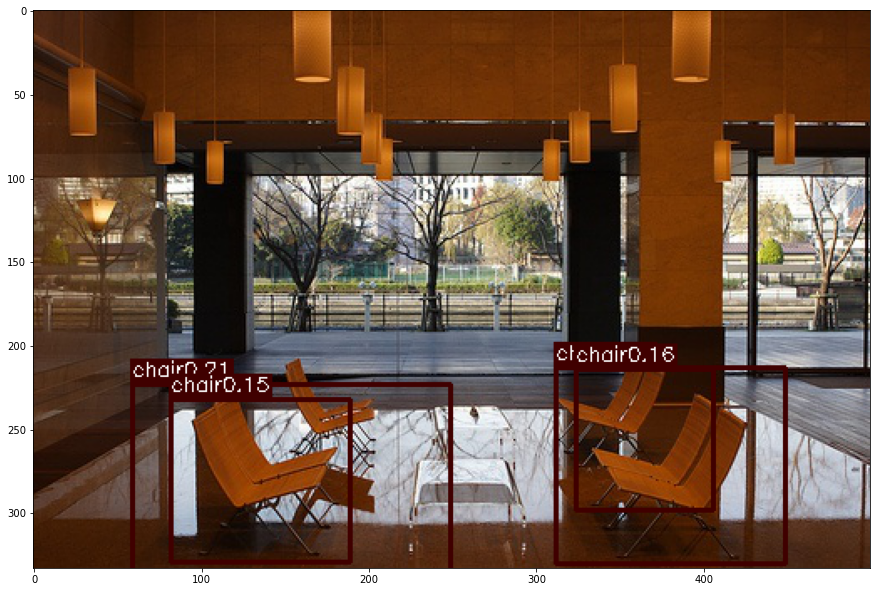

In [10]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)

## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [11]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:40<00:00, 30.82it/s]


---class aeroplane ap 0.5141130665693249---
---class bicycle ap 0.6430645840626876---
---class bird ap 0.5148575577974841---
---class boat ap 0.3103354663591499---
---class bottle ap 0.22710528687858922---
---class bus ap 0.6471529105873111---
---class car ap 0.6930355599763487---
---class cat ap 0.6968691670126037---
---class chair ap 0.28935996532246244---
---class cow ap 0.5582986953369841---
---class diningtable ap 0.43423132992233204---
---class dog ap 0.597435291530422---
---class horse ap 0.7056977520529053---
---class motorbike ap 0.5605319628709657---
---class person ap 0.5566037256709077---
---class pottedplant ap 0.1935119388925991---
---class sheep ap 0.4352343820015909---
---class sofa ap 0.4734056728648853---
---class train ap 0.6771363203811671---
---class tvmonitor ap 0.5182744517092017---
---map 0.5123127543899961---


In [12]:
output_submission_csv('my_solution.csv', test_aps)